# The heat equation in 1D

$$
\renewcommand{\DdQq}[2]{{\mathrm D}_{#1}{\mathrm Q}_{#2}}
\renewcommand{\drondt}{\partial_t}
\renewcommand{\drondx}{\partial_x}
\renewcommand{\drondtt}{\partial_{tt}}
\renewcommand{\drondxx}{\partial_{xx}}
\renewcommand{\drondyy}{\partial_{yy}}
\renewcommand{\dx}{\Delta x}
\renewcommand{\dt}{\Delta t}
\renewcommand{\grandO}{{\mathcal O}}
\renewcommand{\density}[2]{\,f_{#1}^{#2}}
\renewcommand{\fk}[1]{\density{#1}{\vphantom{\star}}}
\renewcommand{\fks}[1]{\density{#1}{\star}}
\renewcommand{\moment}[2]{\,m_{#1}^{#2}}
\renewcommand{\mk}[1]{\moment{#1}{\vphantom{\star}}}
\renewcommand{\mke}[1]{\moment{#1}{e}}
\renewcommand{\mks}[1]{\moment{#1}{\star}}
$$

In this tutorial, we test a very classical lattice Boltzmann scheme $\DdQq{1}{3}$ on the heat equation.

The problem reads
$$
\begin{gathered} \drondt u = \mu \drondxx u, \quad t>0, \quad x\in(0,1),\\ u(0) = u(1) = 0, \end{gathered}
$$
where $\mu$ is a constant scalar.

In [1]:
from __future__ import print_function, division
from six.moves import range
%matplotlib inline

## The scheme $\DdQq{1}{3}$

The numerical simulation of this equation by a lattice Boltzmann scheme consists in the approximatation of the solution on discret points of $(0,1)$ at discret instants.

To simulate this system of equations, we use the $\DdQq{1}{3}$ scheme given by

* three velocities $v_0=0$, $v_1=1$, and $v_2=-1$, with associated distribution functions $\fk{0}$, $\fk{1}$, and $\fk{2}$,
* a space step $\dx$ and a time step $\dt$, the ration $\lambda=\dx/\dt$ is called the scheme velocity,
* three moments
  $$ \mk{0}=\sum_{i=0}^{2} \fk{i}, \quad \mk{1}= \sum_{i=0}^{2} v_i \fk{i}, \quad \mk{2}= \frac{1}{2} \sum_{i=0}^{2} v_i^2 \fk{i},$$
  
  and their equilibrium values $\mke{0}$, $\mke{1}$, and $\mke{2}$.
* two relaxation parameters $s_1$ and $s_2$ lying in $[0,2]$.

In order to use the formalism of the package pyLBM, we introduce the three polynomials that define the moments: $P_0 = 1$, $P_1=X$, and $P_2=X^2/2$, such that
$$ \mk{k} = \sum_{i=0}^2 P_k(v_i) \fk{i}.$$

The transformation $(\fk{0}, \fk{1}, \fk{2})\mapsto(\mk{0},\mk{1}, \mk{2})$ is invertible if, and only if, the polynomials $(P_0,P_1,P_2)$ is a free set over the stencil of velocities.

The lattice Boltzmann method consists to compute the distribution functions $\fk{0}$, $\fk{1}$, and $\fk{2}$ in each point of the lattice $x$ and at each time $t^n=n\dt$.
A step of the scheme can be read as a splitting between the relaxation phase and the transport phase:

* relaxation: 
$$
    \begin{aligned}\mks{1}(t,x)&=(1-s_1)\mk{1}(t,x)+s_1\mke{1}(t,x),\\ \mks{2}(t,x)&=(1-s_2)\mk{2}(t,x)+s_2\mke{2}(t,x).\end{aligned}
$$    

* m2f: 
$$
    \begin{aligned}\fks{0}(t,x)&\;=\mk{0}(t,x)-2\mks{2}(t,x), \\ \fks{1}(t,x)&\;=\mks{1}(t,x)/2+\mks{2}(t,x), \\ \fks{2}(t,x)&\;=-\mks{1}(t,x)/2+\mks{2}(t,x).\end{aligned}
    $$

* transport: 
$$
    \begin{aligned} \fk{0}(t+\dt, x)&\;=\fks{0}(t,x), \\ \fk{1}(t+\dt, x)&\;=\fks{1}(t,x-\dx), \\ \fk{2}(t+\dt, x)&\;=\fks{2}(t,x+\dx). \end{aligned}
    $$

* f2m:
$$
    \begin{aligned}\mk{0}(t+\dt,x)&\;=\fk{0}(t+\dt,x)+\fk{1}(t+\dt,x)+\fk{2}(t+\dt,x), \\ \mk{1}(t+\dt,x)&\;=\fk{1}(t+\dt,x)-\fk{2}(t+\dt,x), \\ \mk{2}(t+\dt,x)&\;=\tfrac{1}{2}\fk{1}(t+\dt,x)+\tfrac{1}{2}\fk{2}(t+\dt,x).\end{aligned}
$$

The moment of order $0$, $\mk{0}$, being conserved during the relaxation phase, 
a diffusive scaling $\dt=\dx^2$, yields to the following equivalent equation
$$\drondt\mk{0} = 2\bigl(\tfrac{1}{s_1}-\tfrac{1}{2}\bigr) \drondxx\mke{2} + \grandO(\dx^2),$$

if $\mke{1}=0$.
In order to be consistent with the heat equation, the following choice is done:
$$\mke{2}=\tfrac{1}{2}u, \qquad s_1 = \frac{2}{1+2\mu}, \qquad s_2=1.$$


## Using pyLBM

pyLBM uses Python dictionary to describe the simulation. In the following, we will build this dictionary step by step.

### The geometry

In pyLBM, the geometry is defined by a box and a label for the boundaries.

Geometry informations
	 spatial dimension: 1
	 bounds of the box: 
[[ 0.  1.]]



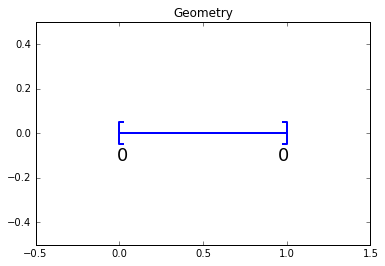

In [2]:
import pyLBM
import numpy as np
xmin, xmax = 0., 1.
dico_geom = {
    'box': {'x': [xmin, xmax], 'label':0},
}
geom = pyLBM.Geometry(dico_geom)
print(geom)
geom.visualize(viewlabel=True)

### The stencil

pyLBM provides a class stencil that is used to define the discret velocities of the scheme. In this example, the stencil is composed by the velocities $v_0=0$, $v_1=1$ and $v_2=-1$ numbered by $[0,1,2]$.

Stencil informations
	 * spatial dimension: 1
	 * maximal velocity in each direction: [1]
	 * minimal velocity in each direction: [-1]
	 * Informations for each elementary stencil:
		stencil 0
		 - number of velocities:  3
		 - velocities: (0: 0), (1: 1), (2: -1), 



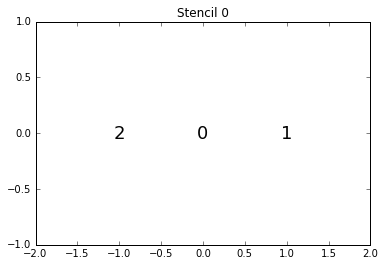

In [3]:
dico_sten = {
    'dim':1,
    'schemes':[{'velocities':list(range(3))}],
}
sten = pyLBM.Stencil(dico_sten)
print(sten)
sten.visualize()

### The domain

In order to build the domain of the simulation, the dictionary should contain the space step $\dx$ and the stencils of the velocities (one for each scheme). 

We construct a domain with $N=10$ points in space.

Domain informations
	 spatial dimension: 1
	 space step: dx= 1.000e-01



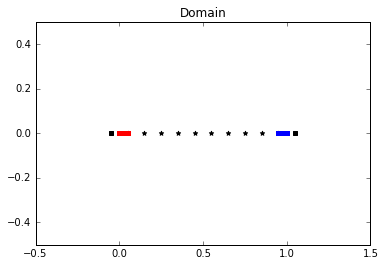

In [4]:
N = 10
dx = (xmax-xmin)/N
dico_dom = {
    'box': {'x': [xmin, xmax], 'label':0},
    'space_step':dx,
    'schemes':[
        {
            'velocities':list(range(3)),
        }
    ],
}
dom = pyLBM.Domain(dico_dom)
print(dom)
dom.visualize()

### The scheme

In pyLBM, a simulation can be performed by using several coupled schemes. In this example, a single scheme is used and defined through a list of one single dictionary. This dictionary should contain:

* 'velocities': a list of the velocities
* 'conserved_moments': a list of the conserved moments as sympy variables
* 'polynomials': a list of the polynomials that define the moments
* 'equilibrium': a list of the equilibrium value of all the moments
* 'relaxation_parameters': a list of the relaxation parameters ($0$ for the conserved moments)
* 'init': a dictionary to initialize the conserved moments

(see the documentation for more details)

The scheme velocity could be taken to $1/\dx$ and the inital value of $u$ to

$$ u(t=0,x) = \sin(\pi x).$$

In [5]:
import sympy as sp

def solution(x, t):
    return np.sin(np.pi*x)*np.exp(-np.pi**2*mu*t)

# parameters
mu = 1.
la = 1./dx
s1 = 2./(1+2*mu)
s2 = 1.
u, X = sp.symbols('u, X')

dico_sch = {
    'dim':1,
    'scheme_velocity':la,
    'schemes':[
        {
            'velocities':list(range(3)),
            'conserved_moments':u,
            'polynomials':[1, X, X**2/2],
            'equilibrium':[u, 0., .5*u],
            'relaxation_parameters':[0., s1, s2],
            'init':{u:(solution, (0.,))},
        }
    ],
}

sch = pyLBM.Scheme(dico_sch)
print(sch)

[0] WARNING  pyLBM.scheme in function __init__ line 229
The value 'space_step' is not given or wrong.
The scheme takes default value: dx = 1.
The scheme takes default value: dx = 1.


Scheme informations
	 spatial dimension: dim=1
	 number of schemes: nscheme=1
	 number of velocities:
    Stencil.nv[0]=3
	 velocities value:
    v[0]=(0: 0), (1: 1), (2: -1), 
	 polynomials:
    P[0]=Matrix([[1], [X], [X**2/2]])
	 equilibria:
    EQ[0]=Matrix([[u], [0.0], [0.5*u]])
	 relaxation parameters:
    s[0]=[0.0, 0.6666666666666666, 1.0]
	 moments matrices
M = [Matrix([
[1,   1,   1],
[0,   1,  -1],
[0, 1/2, 1/2]])]
invM = [Matrix([
[1,    0, -2],
[0,  1/2,  1],
[0, -1/2,  1]])]



### The simulation

A simulation is built by defining a correct dictionary.

We combine the previous dictionaries to build a simulation. In order to impose the homogeneous Dirichlet conditions in $x=0$ and $x=1$, the dictionary should contain the key 'boundary_conditions' (we use pyLBM.bc.Anti_bounce_back function).

In [6]:
dico = {
    'box':{'x':[xmin, xmax], 'label':0},
    'space_step':dx,
    'scheme_velocity':la,
    'schemes':[
        {
            'velocities':list(range(3)),
            'conserved_moments':u,
            'polynomials':[1, X, X**2/2],
            'equilibrium':[u, 0., .5*u],
            'relaxation_parameters':[0., s1, s2],
            'init':{u:(solution,(0.,))},
        }
    ],
    'boundary_conditions':{
        0:{'method':{0:pyLBM.bc.anti_bounce_back,}, 'value':None},
    },
}

sol = pyLBM.Simulation(dico)
print(sol)

Simulation informations: 
Domain informations
	 spatial dimension: 1
	 space step: dx= 1.000e-01
Scheme informations
	 spatial dimension: dim=1
	 number of schemes: nscheme=1
	 number of velocities:
    Stencil.nv[0]=3
	 velocities value:
    v[0]=(0: 0), (1: 1), (2: -1), 
	 polynomials:
    P[0]=Matrix([[1], [X], [X**2/2]])
	 equilibria:
    EQ[0]=Matrix([[u], [0.0], [0.5*u]])
	 relaxation parameters:
    s[0]=[0.0, 0.6666666666666666, 1.0]
	 moments matrices
M = [Matrix([
[1,   1,   1],
[0,   1,  -1],
[0, 1/2, 1/2]])]
invM = [Matrix([
[1,    0, -2],
[0,  1/2,  1],
[0, -1/2,  1]])]



### Run a simulation

Once the simulation is initialized, one time step can be performed by using the function one_time_step.

We compute the solution of the heat equation at $t=0.1$. And, on the same graphic, we plot the initial condition, the exact solution and the numerical solution.

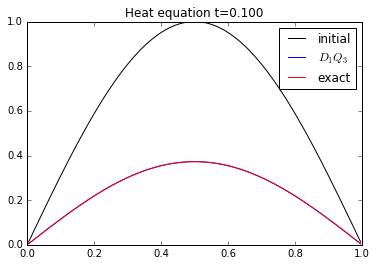

In [7]:
import numpy as np
import sympy as sp
import pylab as plt
import pyLBM

u, X = sp.symbols('u, X')

def solution(x, t):
    return np.sin(np.pi*x)*np.exp(-np.pi**2*mu*t)

xmin, xmax = 0., 1.
N = 128
mu = 1.
Tf = .1
dx = (xmax-xmin)/N # spatial step
la = 1./dx
s1 = 2./(1+2*mu)
s2 = 1.
dico = {
    'box':{'x':[xmin,xmax], 'label':0},
    'space_step':dx,
    'scheme_velocity':la,
    'schemes':[
        {
            'velocities':list(range(3)),
            'conserved_moments':u,
            'polynomials':[1, X, X**2/2],
            'equilibrium':[u, 0., .5*u],
            'relaxation_parameters':[0., s1, s2],
            'init':{u:(solution,(0.,))},
        }
    ],
    'boundary_conditions':{
        0:{'method':{0:pyLBM.bc.anti_bounce_back,}, 'value':None},
    },
}

sol = pyLBM.Simulation(dico)
x = sol.domain.x
y = sol.m[u]

plt.figure(1)
plt.plot(x, y,'k', label='initial')

while sol.t < 0.1:
    sol.one_time_step()

plt.plot(x, y,'b', label=r'$D_1Q_3$')
plt.plot(x, solution(x, sol.t),'r', label='exact')
plt.title('Heat equation t={0:5.3f}'.format(sol.t))
plt.legend()